In [6]:
import pandas as pd
import os
import glob
import re

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Creación del dataframe

path = os.getcwd()
csv_files = glob.glob(os.path.join("./", "dataset/*.csv"))
#print(csv_files)

dataset = pd.DataFrame()

for f in csv_files:
    brand = re.sub(r'\.\/dataset\\', "", f)
    brand = brand.replace(".csv", "")
    
    df = pd.read_csv(f)
    df["brand"] = brand
    
    tax_c = [x for x in df.columns if re.match(r'tax', x)]
    
    if "tax" not in tax_c and tax_c != []:
        tax_c_str = tax_c[0]
        df.rename(columns = {tax_c_str : 'tax'}, inplace = True)
    
    dataset = dataset.append(df)
    
#dataset = dataset.dropna(axis = 1)
dataset = dataset.fillna(0)

#Quitamos los engines que tienen tamaño 0, porque no tiene sentido
dataset = dataset[dataset["engineSize"] != 0]
#Quitamos los coches que son del año 1970 y 2060, son solo dos coches --> outliers
dataset = dataset[(dataset["year"] != 2060) & (dataset["year"] != 1970)]

print(dataset)

      model  year  price transmission  mileage fuelType    tax   mpg  \
0        A1  2017  12500       Manual    15735   Petrol  150.0  55.4   
1        A6  2016  16500    Automatic    36203   Diesel   20.0  64.2   
2        A1  2016  11000       Manual    29946   Petrol   30.0  55.4   
3        A4  2017  16800    Automatic    25952   Diesel  145.0  67.3   
4        A3  2019  17300       Manual     1998   Petrol  145.0  49.6   
...     ...   ...    ...          ...      ...      ...    ...   ...   
15152   Eos  2012   5990       Manual    74000   Diesel  125.0  58.9   
15153   Fox  2008   1799       Manual    88102   Petrol  145.0  46.3   
15154   Fox  2009   1590       Manual    70000   Petrol  200.0  42.0   
15155   Fox  2006   1250       Manual    82704   Petrol  150.0  46.3   
15156   Fox  2007   2295       Manual    74000   Petrol  145.0  46.3   

       engineSize brand  
0             1.4  audi  
1             2.0  audi  
2             1.4  audi  
3             2.0  audi  
4    

(array([2.1180e+03, 2.3981e+04, 3.0357e+04, 2.2619e+04, 1.2283e+04,
        8.0380e+03, 4.0690e+03, 1.7980e+03, 9.6000e+02, 8.2300e+02,
        4.4200e+02, 3.0800e+02, 1.3100e+02, 1.3600e+02, 5.6000e+01,
        3.9000e+01, 1.3000e+01, 1.8000e+01, 8.0000e+00, 7.0000e+00,
        7.0000e+00, 7.0000e+00, 2.0000e+00, 5.0000e+00, 4.0000e+00,
        7.0000e+00, 2.0000e+00, 9.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00]),
 array([     0,   5000,  10000,  15000,  20000,  25000,  30000,  35000,
         40000,  45000,  50000,  55000,  60000,  65000,  70000,  75000,
         80000,  85000,  90000,  95000, 100000, 105000, 110000, 115000,
        120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000]),
 <a list of 31 Patch objects>)

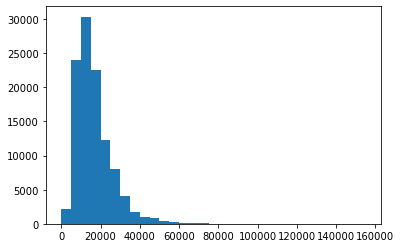

In [12]:
bins = np.arange(0, 160000, 5000)
plt.hist(dataset['price'], bins = bins)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


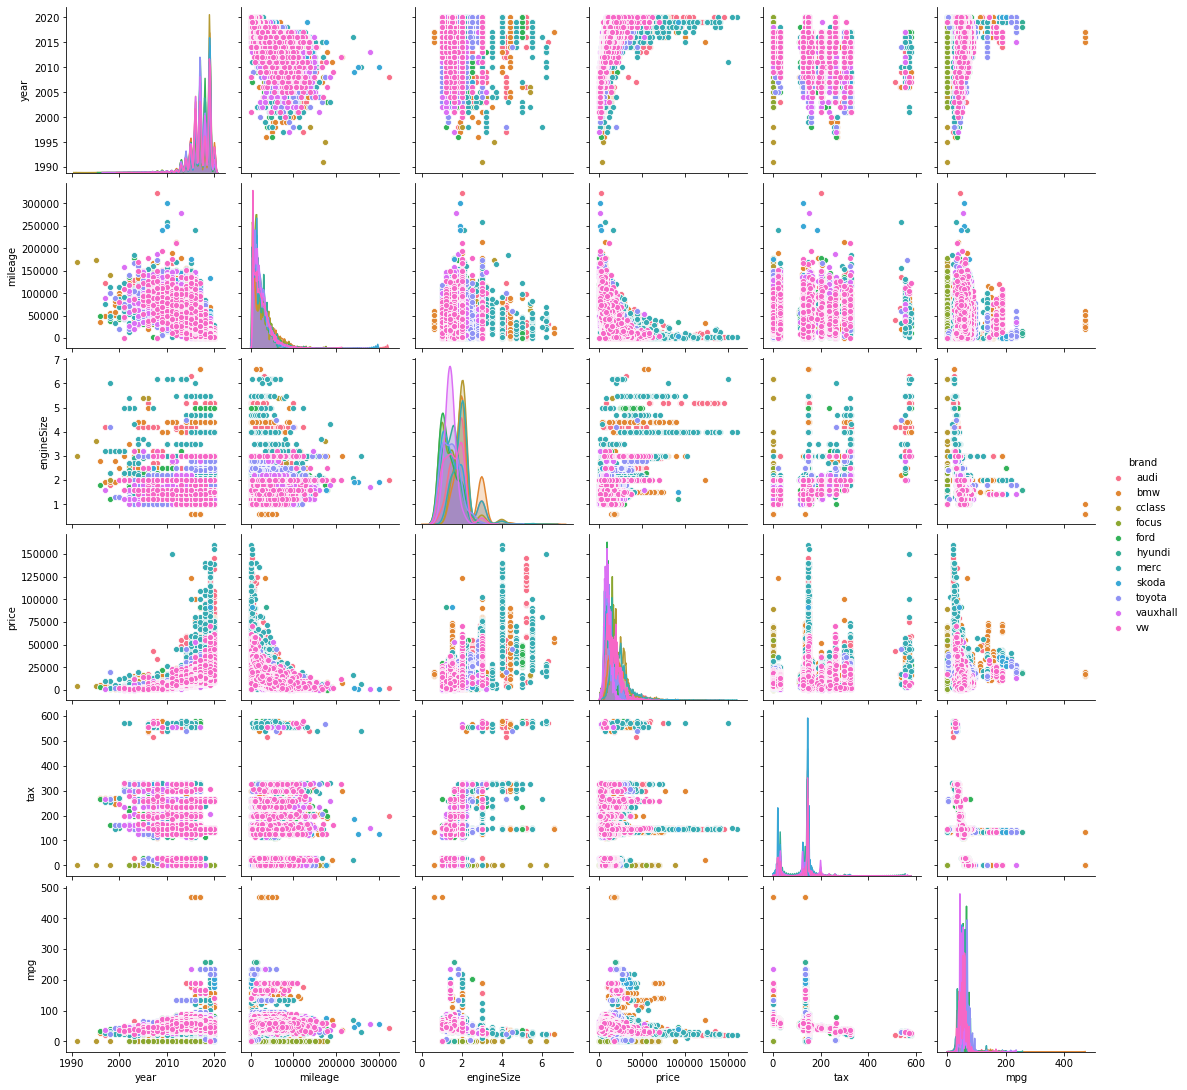

In [3]:
# Visualización de datos

sns.pairplot(dataset[['year', 'mileage', 'engineSize', 'price', 'tax', 'mpg', 'brand']], hue='brand', diag_kws={'bw': 0.2})

In [8]:
# Preprocesamiento de datos

scaler = preprocessing.MinMaxScaler()
label_enc = preprocessing.LabelEncoder()

# Datos a regularizar
reg_data = ['year', 'mileage', 'engineSize']

# Datos a etiquetar
#lab_data = ['model', 'transmission', 'fuelType', 'brand']

dataset = dataset.drop(columns = 'model')
lab_data = ['transmission', 'fuelType', 'brand']

dataset[reg_data] = scaler.fit_transform(dataset[reg_data])

for c in lab_data:
    #dataset[c] = label_enc.fit_transform(dataset[c])
    
    ohe_df = pd.get_dummies(dataset[c], prefix = c)
    dataset = pd.concat([dataset, ohe_df], axis=1)
    dataset = dataset.drop(columns = c)  
    
dataset = dataset.sample(frac = 1, random_state = 4815)
y = dataset['price']
X = dataset.drop(columns = 'price')

print(X)
print(y)

           year   mileage    tax   mpg  engineSize  transmission_Automatic  \
17248  0.586207  0.235292  205.0  43.5    0.116667                       0   
1890   0.965517  0.010833  145.0  56.5    0.233333                       0   
4368   0.965517  0.034053  145.0  32.1    0.233333                       0   
17652  0.827586  0.024146  150.0  47.9    0.166667                       1   
13251  0.931034  0.059266  145.0  54.3    0.233333                       0   
...         ...       ...    ...   ...         ...                     ...   
5388   0.965517  0.015477  145.0  60.1    0.066667                       0   
1946   0.931034  0.036842  145.0  60.1    0.066667                       0   
2006   0.965517  0.030653  145.0  47.9    0.233333                       0   
639    0.862069  0.135394  125.0  60.1    0.233333                       0   
2282   0.896552  0.072914  145.0  72.4    0.150000                       0   

       transmission_Manual  transmission_Other  transmission_Se

In [9]:
# Regresión lineal

lin_reg = LinearRegression()

cross_val_score(lin_reg, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')

array([-4433.49871899, -4745.23188615, -4325.99616437, -4583.42931405,
       -4686.55576254])

In [10]:
# Random Tree Regressor

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits = 5, random_state = 4815, shuffle = True)

parameters = {
    'n_estimators' : np.arange(100, 500, 10),
    'criterion' : ('mse', 'mae'),    
}

rnd_forest_reg = RandomForestRegressor()
rs = RandomizedSearchCV(rnd_forest_reg, parameters, n_iter = 25, verbose = 1, n_jobs = -1, cv = 3, random_state = 4815)

X_forest = X.drop(X.tail(30000).index)
y_forest = y.drop(y.tail(30000).index)

for train_index, test_index in kf.split(X_forest):
    #print("\nTRAIN: [", train_index[0], " ... ", train_index[-1], "", "TEST:", test_index)
    print("TRAIN: [{} ... {}], TEST: [{} ... {}]".format(train_index[0], train_index[-1], test_index[0], test_index[-1]))
    X_train, X_test = X_forest.iloc[train_index], X_forest.iloc[test_index]
    y_train, y_test = y_forest.iloc[train_index], y_forest.iloc[test_index]
    
    search = rs.fit(X_train, y_train)
    best_params = search.best_params_
    
    print("Mejores parámetros encontrados:")
    print(best_params)
    
    rnd_forest_reg.set_params(**best_params)
    rnd_forest_reg.fit(X_train, y_train)
    
    y_pred = rnd_forest_reg.predict(X_test)
    
    print("RMSE: {}".format(mean_squared_error(y_test, y_pred, squared = False)))

TRAIN: [0 ... 12988], TEST: [1 ... 12980]
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 60.9min finished


Mejores parámetros encontrados:
{'n_estimators': 200, 'criterion': 'mse'}
RMSE: 2628.695084313681
TRAIN: [0 ... 12988], TEST: [3 ... 12985]
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 60.1min finished


Mejores parámetros encontrados:
{'n_estimators': 200, 'criterion': 'mse'}
RMSE: 2472.8729869400827
TRAIN: [0 ... 12988], TEST: [4 ... 12984]
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 59.3min finished


Mejores parámetros encontrados:
{'n_estimators': 430, 'criterion': 'mse'}
RMSE: 2579.2296026762724
TRAIN: [0 ... 12985], TEST: [6 ... 12988]
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 62.3min finished


Mejores parámetros encontrados:
{'n_estimators': 370, 'criterion': 'mae'}
RMSE: 3270.4697086383785
TRAIN: [1 ... 12988], TEST: [0 ... 12981]
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 59.9min finished


Mejores parámetros encontrados:
{'n_estimators': 430, 'criterion': 'mse'}
RMSE: 2861.1356452224904
